Run the cells below:

In [1]:
import pandas as pd
import statsmodels.api as sm
import pandas_datareader as pdr

From the St. Louis FRED, download data on monthly US industrial production ('IPROD') and US policy uncertainty ('USEPUINDXM') from 1985 to 2020 (inclusive). 

In [2]:
df = pdr.DataReader(name=['INDPRO','USEPUINDXM'], data_source='fred',
                   start = '1985-01-01', end = '2020-12-31')

df.rename(columns = {'INDPRO':'IPRO', 'USEPUINDXM':'EPU'}, inplace = True)
df.head()

,IPRO,EPU
DATE,,
1985-01-01,54.7203,125.22474
1985-02-01,54.9100,99.02081
1985-03-01,54.9841,112.19051
1985-04-01,54.8853,102.81133
1985-05-01,54.9520,120.08273


In [3]:
df['future_IPRO'] = df['IPRO'].shift(-6)
df['const'] = 1
df = df.dropna()
df

,IPRO,EPU,future_IPRO,const
DATE,,,,
1985-01-01,54.7203,125.22474,54.6420,1
1985-02-01,54.9100,99.02081,54.8269,1
1985-03-01,54.9841,112.19051,55.0447,1
1985-04-01,54.8853,102.81133,54.8418,1
1985-05-01,54.9520,120.08273,55.0381,1
...,...,...,...,...
2020-02-01,101.3247,160.51564,95.8924,1
2020-03-01,97.4477,283.14722,95.6019,1
2020-04-01,84.2018,268.61639,96.6454,1


Create autocorrelation plots for ``EPU`` and ``future_IPRO``.

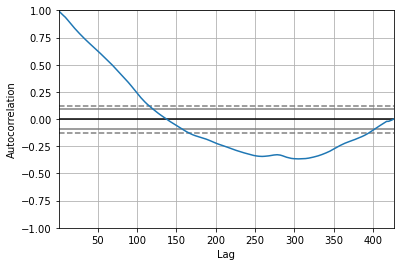

In [4]:
pd.plotting.autocorrelation_plot(df['future_IPRO']);

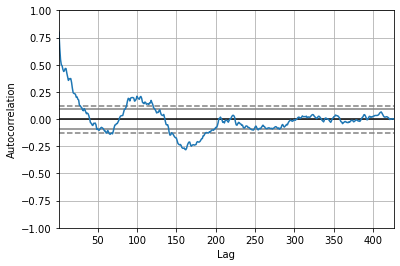

In [5]:
pd.plotting.autocorrelation_plot(df['EPU']);

Test if ``EPU`` and ``future_IPRO`` are non-stationary at the 95\% confidence level.

In [6]:
import statsmodels.tsa.stattools as st

In [7]:
future_ipro_adf = st.adfuller(df['future_IPRO'])
print("P-value = ", future_ipro_adf[1])

P-value =  0.3851450432441017


In [8]:
future_epu_adf = st.adfuller(df['EPU'])
print("P-value = ", future_epu_adf[1])

P-value =  0.6246983009254627


A: both of the above p-values are larger than 5\%, so we can not reject non-stationarity for either ``EPU`` or ``future_IPRO``.

Create 12-month differences (current value minus value from 12 months ago) in both ``EPU`` and ``future_IPRO``. Call these variables ``diff_EPU`` and ``diff_IPRO``.

In [9]:
df[['diff_EPU','diff_IPRO']] = df[['EPU','future_IPRO']].diff(12)
df.head()

,IPRO,EPU,future_IPRO,const,diff_EPU,diff_IPRO
DATE,,,,,,
1985-01-01,54.7203,125.22474,54.6420,1,NaN,NaN
1985-02-01,54.9100,99.02081,54.8269,1,NaN,NaN
1985-03-01,54.9841,112.19051,55.0447,1,NaN,NaN
1985-04-01,54.8853,102.81133,54.8418,1,NaN,NaN
1985-05-01,54.9520,120.08273,55.0381,1,NaN,NaN


Test if ``diff_EPU`` and ``diff_IPRO`` are non-stationary at the 95\% confidence level.

In [10]:
future_ipro_adf = st.adfuller(df['diff_IPRO'].dropna())
print("P-value = ", future_ipro_adf[1])

P-value =  0.004368152079216065


In [11]:
future_epu_adf = st.adfuller(df['diff_EPU'].dropna())
print("P-value = ", future_epu_adf[1])

P-value =  0.045376210754213143


A: both of the above p-values are smaller than 5\%, so we can reject non-stationarity for both ``EPU`` and ``future_IPRO``.

Regress ``diff_IPRO`` on ``diff_EPU`` (and a constant). Use a heteroskedasticity-and-autocorrelation consistent (HAC) covariance estimator to control for autocorrelated standard errors.

In [12]:
res = sm.OLS(endog = df['diff_IPRO'],
            exog = df[['const','diff_EPU']],
            missing = 'drop').fit()

In [13]:
res.nobs**0.25

4.51076378780532

In [14]:
results_hac = res.get_robustcov_results(cov_type = 'HAC', maxlags = 4)
print(results_hac.summary())

                            OLS Regression Results                            
Dep. Variable:              diff_IPRO   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     21.44
Date:                Thu, 03 Mar 2022   Prob (F-statistic):           4.90e-06
Time:                        11:30:27   Log-Likelihood:                -1100.4
No. Observations:                 414   AIC:                             2205.
Df Residuals:                     412   BIC:                             2213.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2400      0.334      3.717      0.0

Using the results of your regression, is policy uncertainty a significant predictor of future industrial production at the 95\% confidence level?

A: Yes, because the p-value of the ``diff_EPU`` coefficient is smaller than 5\%:

In [15]:
results_hac.pvalues 

array([2.29793173e-04, 4.90310579e-06])